In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import src.preprocessing as prepro
import src.data_handler as data_handler
from src.models import LinealReg

raw_data : data_handler.RawData = data_handler.RawData()

/home/nazar/UDESA/5toCUATRIMESTRE/ML/TPs


In [2]:
engineered_data : data_handler.ProcessedData = data_handler.ProcessedData(correct_data_types=False, standarize=False, area_units='m2')
engineered_data.fill_missing_values(method='mean')
engineered_data.casas_dev['high_latitude'] = np.where(engineered_data.casas_dev['lat'] > 0, True, False)
engineered_data.casas_dev['rooms_per_area'] = engineered_data.casas_dev['rooms'] / engineered_data.casas_dev['area']
engineered_data.casas_dev['log_area'] = np.log(engineered_data.casas_dev['area'])
engineered_data.casas_dev = engineered_data.casas_dev.drop(columns=['lon', 'lat', 'area_units'])
engineered_data.casas_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            900 non-null    float64
 1   is_house        900 non-null    int64  
 2   has_pool        900 non-null    int64  
 3   age             900 non-null    float64
 4   price           900 non-null    float64
 5   rooms           900 non-null    float64
 6   high_latitude   900 non-null    bool   
 7   rooms_per_area  900 non-null    float64
 8   log_area        900 non-null    float64
dtypes: bool(1), float64(6), int64(2)
memory usage: 57.3 KB


In [3]:
train : pd.DataFrame
validation : pd.DataFrame
train, validation = data_handler.get_train_and_validation_sets(engineered_data.casas_dev, train_fraction=0.8, seed=42)
train_standarized : pd.DataFrame = prepro.standarize_numeric_columns(train, excluded_columns=set(['lat', 'lon', 'is_house', 'has_pool', 'area_units', 'high_latitude']))
validation_standarized : pd.DataFrame = prepro.standarize_numeric_columns(validation, excluded_columns=set(['lat', 'lon', 'is_house', 'has_pool', 'area_units', 'high_latitude']))
train_standarized.head()

,area,is_house,has_pool,age,price,rooms,high_latitude,rooms_per_area,log_area
70,-0.454611,0,0,0.191565,0.469669,-0.828209,True,-0.846953,-0.326818
827,0.173135,0,0,-0.709917,0.880550,0.271995,True,0.132921,0.323658
231,1.395587,0,0,-0.033806,-0.734041,1.372199,False,-0.015283,1.295449
588,-0.751964,1,1,-0.033806,0.819786,-0.828209,True,-0.277259,-0.690403
39,1.957254,1,0,1.318418,-0.563323,1.372199,False,-0.610197,1.656530


5.2 )

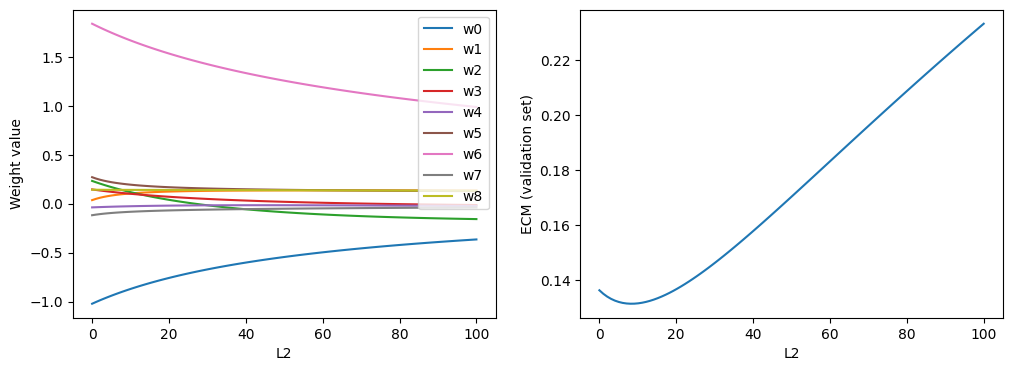

ECM alcanza un mínimo (ECM = 0.1316) cuando L2 = 8.0808


In [ ]:
L2s : list[float] = np.linspace(0, 100, 100)
ECM2s : list[float] = []
coefsL2 : list[tuple[float, float, float]] = []
for l in L2s:
    lin : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L2=l)
    lin.fit_pseudo_inverse()
    coefsL2.append(lin.coef)
    ECM2s.append(lin.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy()))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(np.array(coefsL2).shape[1]):
    plt.plot(L2s, np.array(coefsL2)[:, i], label=f'w{i}')
plt.xlabel('L2')
plt.ylabel('Weight value')
plt.legend()
plt.subplot(1, 2, 2)
L2s : list[float] = np.linspace(0, 100, 100)
plt.xlabel('L2')
plt.ylabel('ECM (validation set)')
plt.plot(L2s, ECM2s)
plt.show()
print(f"ECM alcanza un mínimo (ECM = {ECM2s[np.argmin(ECM2s)]:.4f}) cuando L2 = {L2s[np.argmin(ECM2s)]:.4f}")

El error aumenta con regularización L2

5.3 )

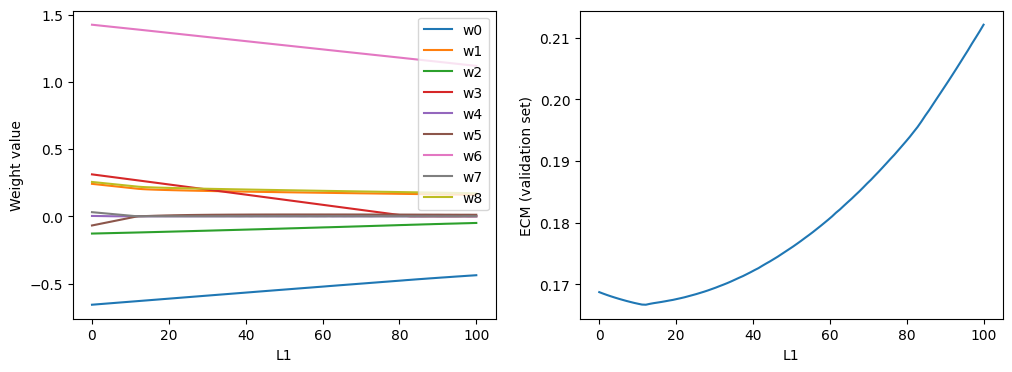

ECM alcanza un mínimo (ECM = 0.1667) cuando L1 = 12.1212


In [ ]:
L1s : list[float] = np.linspace(0, 100, 100)
ECM1s : list[float] = []
coefsL1 : list[tuple[float, float, float]] = []
for l in L1s:
    lin : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L1=l)
    lin.fit_gradient_descent(step_size=0.000005, tolerance=0.5, max_number_of_steps=1000)
    coefsL1.append(lin.coef)
    ECM1s.append(lin.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy()))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(np.array(coefsL1).shape[1]):
    plt.plot(L1s, np.array(coefsL1)[:, i], label=f'w{i}')
plt.xlabel('L1')
plt.ylabel('Weight value')
plt.legend()
plt.subplot(1, 2, 2)
L1s : list[float] = np.linspace(0, 100, 100)
plt.xlabel('L1')
plt.ylabel('ECM (validation set)')
plt.plot(L1s, ECM1s)
plt.show()
print(f"ECM alcanza un mínimo (ECM = {ECM1s[np.argmin(ECM1s)]:.4f}) cuando L1 = {L1s[np.argmin(ECM1s)]:.4f}")

5.4 ) Utilizo el valor de lambda que minimiza ECM. (Vimos en 5.3 que este valor es L2 = 8.08)

In [6]:
lin : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L2=8.08)
lin.fit_pseudo_inverse()
print("PSEUDOINVERSA")
print("  ECM (train set)      : ", lin.error_cuadratico_medio())
print("  ECM (validation set) : ", lin.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy()))
lin : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L2=8.08)
lin.fit_gradient_descent(step_size=0.000005, tolerance=-1, max_number_of_steps=10000)
print("GRADIENTE DESCENDENTE")
print("  ECM (train set)      : ", lin.error_cuadratico_medio())
print("  ECM (validation set) : ", lin.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy()))

PSEUDOINVERSA
  ECM (train set)      :  0.1262966293972657
  ECM (validation set) :  0.13157360771312573
GRADIENTE DESCENDENTE
  ECM (train set)      :  0.12655201004453293
  ECM (validation set) :  0.13141218950193878


Esta regularización restringe al modelo de producir overfitting, ya que penaliza el crecimiento de los coeficientes.

5.5) En los puntos anteriores comprobamos que es posible mejorar el resultado de ECM en el set de validación utilizando regularización.

5.6 )

In [7]:
# MODELOS
print("Número de filas: ", engineered_data.casas_dev.shape[0])
print("20% en filas: ", int(engineered_data.casas_dev.shape[0] / 5))
Ls : np.ndarray = np.arange(0, 10, 0.5)
ECM_models : dict[str, list[float]] = {f'pseudo_L2_{l}' : [] for l in Ls}
ECM_models.update({f'gradient_L1_{l}' : [] for l in Ls})
ECM_models.update({f'gradient_L2_{l}' : [] for l in Ls})
print(ECM_models)
for i in range(1, 5):
    train : pd.DataFrame
    validation : pd.DataFrame
    validation = engineered_data.casas_dev.iloc[(i*180) - 180 : (i*180)]
    train = engineered_data.casas_dev.drop(engineered_data.casas_dev.index[(i*180) - 180 : (i*180)])
    train_standarized : pd.DataFrame = prepro.standarize_numeric_columns(train, excluded_columns=set(['lat', 'lon', 'is_house', 'has_pool', 'area_units', 'high_latitude']))
    validation_standarized : pd.DataFrame = prepro.standarize_numeric_columns(validation, excluded_columns=set(['lat', 'lon', 'is_house', 'has_pool', 'area_units', 'high_latitude']))

    for l in Ls:
        lin_pseudo_L2 : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L2=l)
        lin_pseudo_L2.fit_pseudo_inverse()
        ECM_models[f'pseudo_L2_{l}'].append(
            lin_pseudo_L2.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy())
        )
        lin_grad_L1 : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L1=l)
        lin_grad_L1.fit_gradient_descent(step_size=0.000005, tolerance=-1, max_number_of_steps=10000)
        ECM_models[f'gradient_L1_{l}'].append(
            lin_grad_L1.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy())
        )
        lin_grad_L2 : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L2=l)
        lin_grad_L2.fit_gradient_descent(step_size=0.000005, tolerance=-1, max_number_of_steps=10000)
        ECM_models[f'gradient_L2_{l}'].append(
            lin_grad_L2.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy())
        )


Número de filas:  900
20% en filas:  180
{'pseudo_L2_0.0': [], 'pseudo_L2_0.5': [], 'pseudo_L2_1.0': [], 'pseudo_L2_1.5': [], 'pseudo_L2_2.0': [], 'pseudo_L2_2.5': [], 'pseudo_L2_3.0': [], 'pseudo_L2_3.5': [], 'pseudo_L2_4.0': [], 'pseudo_L2_4.5': [], 'pseudo_L2_5.0': [], 'pseudo_L2_5.5': [], 'pseudo_L2_6.0': [], 'pseudo_L2_6.5': [], 'pseudo_L2_7.0': [], 'pseudo_L2_7.5': [], 'pseudo_L2_8.0': [], 'pseudo_L2_8.5': [], 'pseudo_L2_9.0': [], 'pseudo_L2_9.5': [], 'gradient_L1_0.0': [], 'gradient_L1_0.5': [], 'gradient_L1_1.0': [], 'gradient_L1_1.5': [], 'gradient_L1_2.0': [], 'gradient_L1_2.5': [], 'gradient_L1_3.0': [], 'gradient_L1_3.5': [], 'gradient_L1_4.0': [], 'gradient_L1_4.5': [], 'gradient_L1_5.0': [], 'gradient_L1_5.5': [], 'gradient_L1_6.0': [], 'gradient_L1_6.5': [], 'gradient_L1_7.0': [], 'gradient_L1_7.5': [], 'gradient_L1_8.0': [], 'gradient_L1_8.5': [], 'gradient_L1_9.0': [], 'gradient_L1_9.5': [], 'gradient_L2_0.0': [], 'gradient_L2_0.5': [], 'gradient_L2_1.0': [], 'gradient

In [8]:
print("MODEL              ECM")
print(pd.DataFrame(ECM_models).mean())

MODEL              ECM
pseudo_L2_0.0      0.136718
pseudo_L2_0.5      0.136502
pseudo_L2_1.0      0.136330
pseudo_L2_1.5      0.136198
pseudo_L2_2.0      0.136105
pseudo_L2_2.5      0.136050
pseudo_L2_3.0      0.136029
pseudo_L2_3.5      0.136043
pseudo_L2_4.0      0.136088
pseudo_L2_4.5      0.136164
pseudo_L2_5.0      0.136270
pseudo_L2_5.5      0.136403
pseudo_L2_6.0      0.136563
pseudo_L2_6.5      0.136749
pseudo_L2_7.0      0.136958
pseudo_L2_7.5      0.137192
pseudo_L2_8.0      0.137447
pseudo_L2_8.5      0.137724
pseudo_L2_9.0      0.138022
pseudo_L2_9.5      0.138338
gradient_L1_0.0    0.137271
gradient_L1_0.5    0.137211
gradient_L1_1.0    0.137174
gradient_L1_1.5    0.137157
gradient_L1_2.0    0.137160
gradient_L1_2.5    0.137181
gradient_L1_3.0    0.137220
gradient_L1_3.5    0.137276
gradient_L1_4.0    0.137349
gradient_L1_4.5    0.137438
gradient_L1_5.0    0.137544
gradient_L1_5.5    0.137666
gradient_L1_6.0    0.137804
gradient_L1_6.5    0.137957
gradient_L1_7.0    0.1381

In [9]:
print("TOP 5 MODELS")
print("MODEL            ECM")
print(pd.DataFrame(ECM_models).mean().nsmallest(5))

TOP 5 MODELS
MODEL            ECM
pseudo_L2_3.0    0.136029
pseudo_L2_3.5    0.136043
pseudo_L2_2.5    0.136050
pseudo_L2_4.0    0.136088
pseudo_L2_2.0    0.136105
dtype: float64
